In [18]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from scipy.sparse import vstack
import scipy.stats
import psutil
import math
import matplotlib.pyplot as plt
import cooltools
import cooltools.lib.plotting
from mpl_toolkits.axes_grid1 import make_axes_locatable
import bioframe

In [2]:
# Getting % usage of virtual_memory ( 3rd field)
print('RAM memory % used:', psutil.virtual_memory()[2])
# Getting usage of virtual_memory in GB ( 4th field)
print('RAM Used (GB):', psutil.virtual_memory()[3]/1000000000)

RAM memory % used: 4.2
RAM Used (GB): 2.797334528


In [3]:
data = pd.read_csv('/mnt/g/genomics/10_16_23_CA1/Allsamples_mm10_binned_matrix.txt', header=None,delim_whitespace=True)
cells = pd.read_csv('/mnt/g/genomics/10_16_23_CA1/Allsamples_mm10_cells.txt', header=None,sep='#')
clusters = pd.read_csv('/mnt/g/genomics/10_16_23_CA1/Allsamples_mm10_clusters.txt', header=None)

cell_clusters = pd.concat([cells,clusters],axis=1)
cell_clusters.columns = ['sample','cell','cluster']
print(len(cells),len(clusters))
cell_clusters

17190 17190


,sample,cell,cluster
0,Glut_CA1GL1_sorted2,CEMBA190625_10E.TGGGTATCCAATAGCTGTGTCT,C3
1,Glut_CA1GL1_sorted2,CEMBA190625_10E.ATGGTTTGGGCCCAATACGTGG,C4
2,Glut_CA1GL1_sorted2,CEMBA190219_9H.GGAACACTAGTGGGAGAGTTCT,C5
3,Glut_CA1GL1_sorted2,CEMBA190625_10E.TTTCTGTCGGATAGCGAGTCAC,C4
4,Glut_CA1GL1_sorted2,CEMBA190625_10E.CAGGCCTGTAGCTTACAATCGT,C6
...,...,...,...
17185,Glut_CA1GL3_sorted2,CEMBA190625_10E.TATACTCCGCAATGGAGCAACA,C2
17186,Glut_CA1GL3_sorted2,CEMBA190305_11E.TAACACCGTATGATCACTGCAT,C2
17187,Glut_CA1GL3_sorted2,CEMBA190625_10E.GATCTAGCTCAATCACGCTTCG,C2
17188,Glut_CA1GL3_sorted2,CEMBA190625_10E.TATACTCCGCGCTACAATGTGG,C2


In [4]:
Nregions = 272543 ## number of 10kb-binned mm10 mouse genome (2,730,871,774 bases - google)
Ncells = len(data[1].unique()) # number of unique cells, in all samples combined
print(Nregions,Ncells)

272543 17190


In [5]:
row = np.array(data[0])-1
col = np.array(data[1])-1
val = np.array(data[2])
print(len(row),len(col),len(val))

# creating sparse matrix 
sparseMatrix = csr_matrix((val, (row, col)),shape=(Nregions, Ncells))


96283219 96283219 96283219


In [6]:
uni = cell_clusters['sample'].unique()
len(uni)
dataset = {}
clusters_set = {}
for i in range(len(uni)):
    TF = np.array(cell_clusters['sample']==uni[i])
    dataset[uni[i]] = sparseMatrix[:,TF]
    clusters_set[uni[i]] = cell_clusters['cluster'][TF]

In [7]:
################## fibo down sampling ###########################

In [7]:
Chr10k = pd.read_csv('/mnt/g/genomics/scATACcodes/MatlabCodes/10kResampleBed/mm10_10k.txt', header=None,sep='\t')
Chr10k.columns = ['chrom','start','end']
Chridx = Chr10k['chrom'].unique()

In [8]:
def Fibonacci(n):
    if n<= 0:
        print("Incorrect input")
    # First Fibonacci number is 0
    elif n == 1:
        return 0
    # Second Fibonacci number is 1
    elif n == 2:
        return 1
    else:
        return Fibonacci(n-1)+Fibonacci(n-2)

# M=sparse matrix
# binned_bed=the original binned bed
# combine n-original-bins per new bin
def Binnification(M,binned_bed,n):
    chridx = binned_bed['chrom'].unique()
    BS = np.median(binned_bed['end']-binned_bed['start'])
    BS_new = BS*n
    print('original median BinSize',BS)
    print('new BinSize',BS_new)
    M_temp = []
    bed_temp = []
    bed_lst = []
    for k in range(len(chridx)):        
        chrbool_k = binned_bed['chrom']==chridx[k]
        chridx_k = np.where(chrbool_k)[0]
        old_bin_count = sum(chrbool_k)
        new_bin_count = math.floor(old_bin_count/n)
        print(chridx[k],old_bin_count,new_bin_count)
        M_k = M[chrbool_k,:]
        binned_bed_k = binned_bed[chrbool_k]
        M_temp_k = []
        bed_temp_k = []
        for i in range(new_bin_count):
            a = i*n
            b = i*n+n
            m = sum(M_k[a:b,:])
            M_temp_k.append(m)
            bed_lst.append([chridx[k],int(i*BS_new),int(i*BS_new+BS_new)])
        M_temp.append(vstack(M_temp_k))
    M_binnified = vstack(M_temp)
    bed_binnified = pd.DataFrame(bed_lst, columns = ['chrom', 'start', 'end'])
    return(M_binnified,bed_binnified)



In [19]:
Fibonacci(11)

55

In [20]:
sparseMatrix_binned,Coordinate = Binnification(sparseMatrix,Chr10k,55)

original median BinSize 10000.0
new BinSize 550000.0
chr1 19547 355
chr2 18211 331
chr3 16003 290
chr4 15650 284
chr5 15183 276
chr6 14973 272
chr7 14544 264
chr8 12940 235
chr9 12459 226
chr10 13069 237
chr11 12208 221
chr12 12012 218
chr13 12042 218
chr14 12490 227
chr15 10404 189
chr16 9820 178
chr17 9498 172
chr18 9070 164
chr19 6143 111
chrX 17103 310
chrY 9174 166


In [22]:
scipy.sparse.save_npz('./sparseMatrix_Binned_550kb.npz', sparseMatrix_binned)
Coordinate.to_csv("./Coordinate_Binned_550kb.bed", encoding='utf-8', index=False,sep='\t', header=False)

In [26]:
sparseMatrix_binned = scipy.sparse.load_npz('./sparseMatrix_Binned_1MB.npz')
Coordinate = bioframe.read_table('Coordinate_Binned_1MB.bed',schema='bed3')

In [27]:
sparseMatrix_binned
Coordinate.head()

,chrom,start,end
0,chr1,0,1000000
1,chr1,1000000,2000000
2,chr1,2000000,3000000
3,chr1,3000000,4000000
4,chr1,4000000,5000000


In [11]:
################## visualizing some raw corr data ###########################

In [12]:
def sparseM_subset(M,cell_info,subsetBy,selection_list):
    TF = cell_info[subsetBy].isin(selection_list)
    M_subset = M[:,TF]
    print(selection_list,' subset shape: ',M_subset.get_shape())
    return(M_subset)
def compute_corr_bulk(M, Method):
    df = pd.DataFrame(M.toarray())
    M_corr = df.T.corr(method=Method,min_periods=1,numeric_only=True)
    bulk = np.array(df.sum(axis=1))/len(df.columns)
    return M_corr,bulk
def make_corr_saddle(compute_corrbulk_out,ignore_diag = True):
    M_corr_df = compute_corrbulk_out[0]
    bulk = compute_corrbulk_out[1]
    sort_ind = np.argsort(bulk)
    bulk_sorted = bulk[sort_ind]
    M_corr_df_sorted = np.array(M_corr_df.iloc[sort_ind,sort_ind])
    if ignore_diag == True:
        np.fill_diagonal(M_corr_df_sorted, np.nan)
    else:
        print('main diagonal kept')
    return (M_corr_df_sorted, bulk_sorted)


In [28]:
c1 = ["C5"]   # 'dorsal'
c2 = ["C6"]   # 'ventral'

M_c1 = sparseM_subset(sparseMatrix_binned,cell_clusters,subsetBy='cluster',selection_list=c1)
M_c2 = sparseM_subset(sparseMatrix_binned,cell_clusters,subsetBy='cluster',selection_list=c2)


['C5']  subset shape:  (2716, 5549)
['C6']  subset shape:  (2716, 4404)


In [36]:
sparseMatrix_binned

<2716x17190 sparse matrix of type '<class 'numpy.int64'>'
	with 32069193 stored elements in Compressed Sparse Row format>

In [29]:
M_dats = [M_c1,M_c2]

dats_corr = []
dats_corr_saddle = []
for i in range(len(M_dats)):
    t = compute_corr_bulk(M_dats[i],'spearman')
    u = make_corr_saddle(t,ignore_diag=True)
    dats_corr.append(t)
    dats_corr_saddle.append(u)

In [ ]:
################### need a function to call/annotate axis ########
def genomics_to_matrix(Chromosome,Start,End,sparseM_binned,Coordinate_binned_bed):
    
    


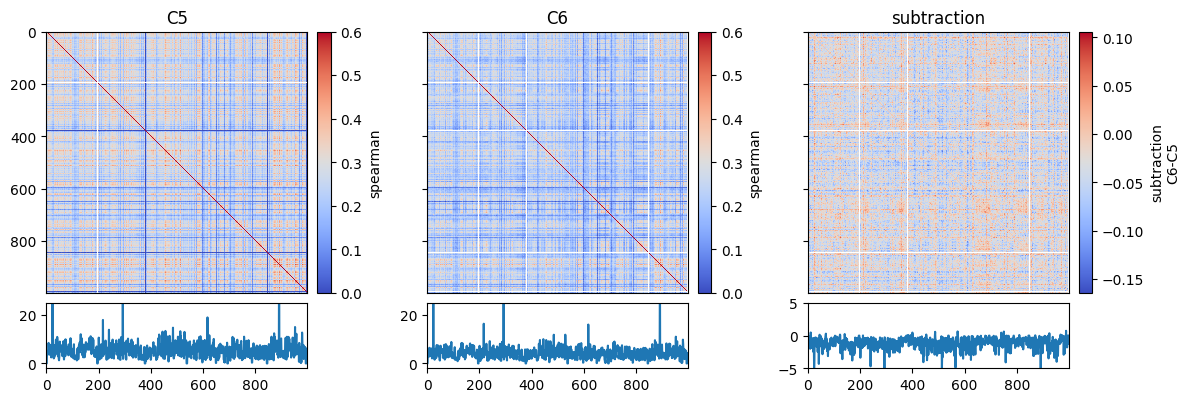

In [35]:
########################### raw matrix ###########################

f, axs = plt.subplots(
    figsize=(12, 6),
    nrows=1,
    ncols=3, # three columns, first two will be regular HiC plot, third will be log2ratio
    sharex='col',
    sharey='row'
)

dats = dats_corr

sub_titles = c1+c2+['subtraction']

vMin,vMax = 0.,0.6
sMin,sMax = -2,25

start,end = 0,1000


### colors to try: 'fall' 'blues' 'acidblues', "nmeth'
for i in range(len(dats)):
    d = dats[i]
    ax = axs[i]
    im = ax.matshow(
        d[0].iloc[start:end,start:end],
        cmap='coolwarm',
        vmin=vMin,vmax=vMax
    );
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(im, cax=cax, label='spearman');
    ax.set_title(sub_titles[i])
    ax.xaxis.set_visible(False)

    ax1 = divider.append_axes("bottom", size="25%", pad=0.1, sharex=ax)
    ax1.plot(d[1][start:end])
    ax1.set_ylim(sMin,sMax)

## contrast plot ####
ax = axs[2]
im = ax.matshow(
    dats[1][0].iloc[start:end,start:end]-dats[0][0].iloc[start:end,start:end],
    cmap='coolwarm',
#    vmin=-0.1,vmax=0.1,
    )
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im, cax=cax, label='subtraction'+'\n'+str(sub_titles[1])+'-'+str(sub_titles[0]));
    
ax.set_title(sub_titles[2])
ax.xaxis.set_visible(False)

ax1 = divider.append_axes("bottom", size="25%", pad=0.1, sharex=ax)
ax1.plot(dats[1][1][start:end]-dats[0][1][start:end])
ax1.set_ylim(-5,5)


plt.tight_layout()

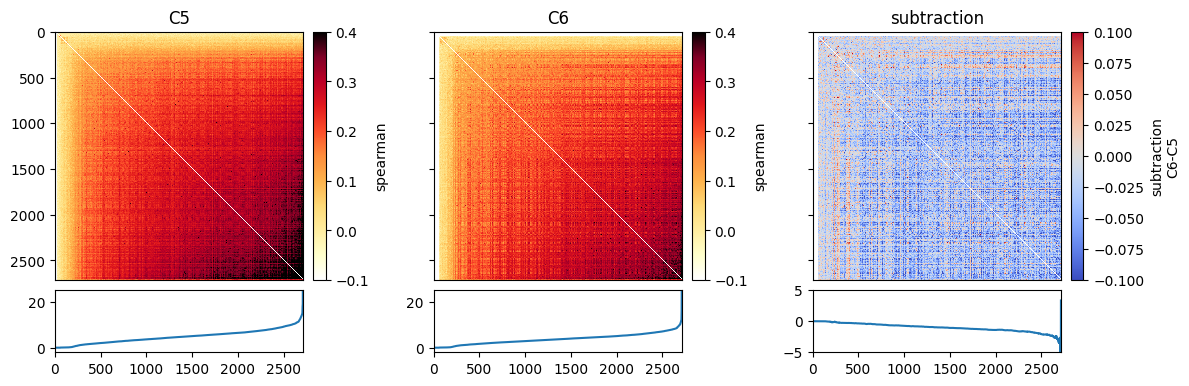

In [59]:
########################### raw matrix ###########################

f, axs = plt.subplots(
    figsize=(12, 6),
    nrows=1,
    ncols=3, # three columns, first two will be regular HiC plot, third will be log2ratio
    sharex='col',
    sharey='row'
)

dats = dats_corr_saddle

sub_titles = c1+c2+['subtraction']

vMin,vMax = -0.1,0.4
sMin,sMax = -2,25

### colors to try: 'fall' 'blues' 'acidblues', "nmeth'
for i in range(len(dats)):
    d = dats[i]
    ax = axs[i]
    im = ax.matshow(
        d[0],
        cmap='fall',
        vmin=vMin,vmax=vMax
    );
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(im, cax=cax, label='spearman');
    ax.set_title(sub_titles[i])
    ax.xaxis.set_visible(False)

    ax1 = divider.append_axes("bottom", size="25%", pad=0.1, sharex=ax)
    ax1.plot(d[1])
    ax1.set_ylim(sMin,sMax)

## contrast plot ####
ax = axs[2]
im = ax.matshow(
    dats[1][0]-dats[0][0],
    cmap='coolwarm',
    vmin=-0.1,vmax=0.1,
    )
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im, cax=cax, label='subtraction'+'\n'+str(sub_titles[1])+'-'+str(sub_titles[0]));
    
ax.set_title(sub_titles[2])
ax.xaxis.set_visible(False)

ax1 = divider.append_axes("bottom", size="25%", pad=0.1, sharex=ax)
ax1.plot(dats[1][1]-dats[0][1])
ax1.set_ylim(-5,5)


plt.tight_layout()

In [ ]:
############################## subset bins that contain gene annotation ################